# Multi-label model

Reminder - https://docs.fast.ai/tutorial.vision.html

Utils - https://docs.fast.ai/vision.utils.html

In [1]:
from fastai.data.all import *
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#9) [Path('/home/nelth/.fastai/data/pascal_2007/valid.json'),Path('/home/nelth/.fastai/data/pascal_2007/test.json'),Path('/home/nelth/.fastai/data/pascal_2007/test'),Path('/home/nelth/.fastai/data/pascal_2007/train.json'),Path('/home/nelth/.fastai/data/pascal_2007/test.csv'),Path('/home/nelth/.fastai/data/pascal_2007/segmentation'),Path('/home/nelth/.fastai/data/pascal_2007/train.csv'),Path('/home/nelth/.fastai/data/pascal_2007/train'),Path('/home/nelth/.fastai/data/pascal_2007/models')]

In [3]:
df = pd.read_csv(path/"train.csv")
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

In [6]:
dls = pascal.dataloaders(df)

/home/nelth/anaconda3/envs/airbnb-furniture-finder/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


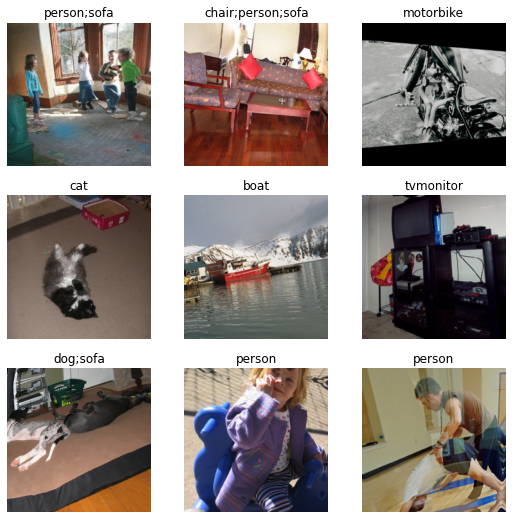

In [7]:
dls.show_batch()

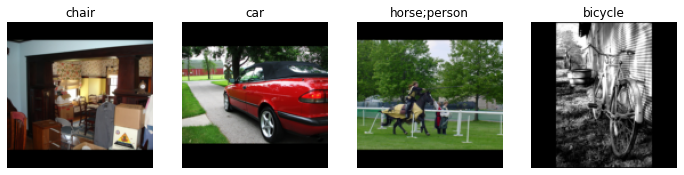

In [8]:
pascal = pascal.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = pascal.dataloaders(df)
dls.valid.show_batch(max_n=4, nrows=1)

In [9]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

SuggestedLRs(valley=0.0014454397605732083)

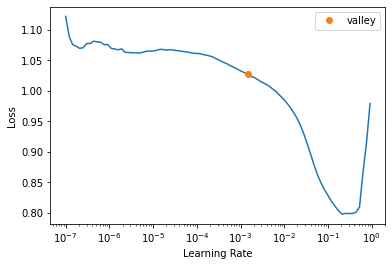

In [10]:
learn.lr_find()

In [11]:
learn.fine_tune(epochs=2, base_lr=3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.503815,0.197630,0.938705,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.204891,7.564979,0.922849,00:09
1,0.179027,0.159584,0.946673,00:09


In [12]:
learn.fine_tune(epochs=5, base_lr=3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.148436,0.178720,0.944621,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.155231,1.946965,0.932132,00:09
1,0.160470,0.294836,0.930677,00:09
2,0.146744,0.158223,0.945398,00:09
3,0.127139,0.191872,0.943566,00:09
4,0.102164,0.144262,0.949143,00:09


## Enhancing our loss and activations functions

In [13]:
x,y = dls.one_batch()

In [14]:
# Checking what's happening inside our categories predictions
y

TensorMultiCategory([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [15]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([0.0033, 0.0659, 0.0022, 0.0071, 0.0596, 0.0034, 0.0351, 0.0620, 0.6119,
        0.0028, 0.0903, 0.0205, 0.0010, 0.0219, 0.1789, 0.3032, 0.0010, 0.2900,
        0.0145, 0.2304])

In [16]:
len(preds[0]), preds[0].sum()

(20, TensorBase(2.0048))

In [17]:
pd.Categorical(df['labels'])

['chair', 'car', 'horse person', 'car', 'bicycle', ..., 'horse person', 'boat', 'person bicycle', 'car', 'dog']
Length: 5011
Categories (473, object): ['aeroplane', 'aeroplane boat', 'aeroplane car', 'aeroplane chair', ..., 'tvmonitor sofa chair', 'tvmonitor sofa person', 'tvmonitor sofa pottedplant', 'tvmonitor sofa pottedplant chair person']

In [18]:
pd.Categorical(df['labels']).categories

Index(['aeroplane', 'aeroplane boat', 'aeroplane car', 'aeroplane chair',
       'aeroplane person', 'aeroplane person car', 'aeroplane sheep',
       'bicycle', 'bicycle boat', 'bicycle bottle',
       ...
       'tvmonitor person sofa', 'tvmonitor pottedplant',
       'tvmonitor pottedplant dog', 'tvmonitor pottedplant sofa',
       'tvmonitor sofa', 'tvmonitor sofa cat', 'tvmonitor sofa chair',
       'tvmonitor sofa person', 'tvmonitor sofa pottedplant',
       'tvmonitor sofa pottedplant chair person'],
      dtype='object', length=473)

In [24]:
for categories in pd.Categorical(df['labels']).categories:
    print(categories.split(' '))

['aeroplane']
['aeroplane', 'boat']
['aeroplane', 'car']
['aeroplane', 'chair']
['aeroplane', 'person']
['aeroplane', 'person', 'car']
['aeroplane', 'sheep']
['bicycle']
['bicycle', 'boat']
['bicycle', 'bottle']
['bicycle', 'car']
['bicycle', 'car', 'person']
['bicycle', 'cat', 'person']
['bicycle', 'chair']
['bicycle', 'diningtable', 'chair']
['bicycle', 'person']
['bicycle', 'person', 'bottle']
['bicycle', 'person', 'bus']
['bicycle', 'person', 'car']
['bicycle', 'person', 'car', 'bus']
['bicycle', 'person', 'chair']
['bicycle', 'person', 'chair', 'sofa', 'pottedplant', 'tvmonitor']
['bicycle', 'person', 'tvmonitor']
['bicycle', 'pottedplant']
['bicycle', 'sofa', 'person']
['bird']
['bird', 'car']
['bird', 'cow']
['bird', 'person']
['bird', 'pottedplant']
['boat']
['boat', 'bird']
['boat', 'bus']
['boat', 'bus', 'car', 'person']
['boat', 'car']
['boat', 'car', 'person']
['boat', 'person']
['boat', 'person', 'dog']
['boat', 'pottedplant', 'chair', 'diningtable', 'person', 'sofa', 'dog

In [23]:
for categories in pd.Categorical(df['labels']):
    print(categories)

chair
car
horse person
car
bicycle
person horse
cat
car
dog person
bicycle person
train
car
bicycle person
aeroplane person
aeroplane
train
person diningtable
dog
tvmonitor
tvmonitor person
train
chair cat
bird
car chair
bird person
chair bottle person
motorbike person
pottedplant
car
boat
dog chair
bird
dog
person
motorbike
pottedplant boat person
cat
dog
sofa person
car person
person chair
car
dog chair
train
cat
chair person
sofa
tvmonitor person
sheep cow
bird
person
dog chair
person
aeroplane
cat
dog
tvmonitor
cat
train
bicycle person
bicycle person
boat
car person
bus
person horse
car
person
dog sofa
bird
car
cat
person
chair
horse person
car
boat
sofa car
bird
person car
car
tvmonitor person
person motorbike
motorbike person
person
car person
bottle person
dog person
person horse
person
diningtable person
car
boat
tvmonitor
bird
bus person
person chair
person sofa
horse person
train
person bottle
chair
bus
diningtable chair sofa
cat
car person
cow
horse
cat
dog chair person
moto

bird
train person
person
dog
cow
bird
sheep
bus person
person
tvmonitor chair sofa
cow person
bicycle person
car
cat
aeroplane
pottedplant person
person
cat sofa chair pottedplant
sofa tvmonitor chair
car
boat
car
diningtable chair sofa tvmonitor
car
horse
horse person
bus
chair person
sofa pottedplant tvmonitor chair bicycle person
car horse person
aeroplane
cat person
aeroplane car
diningtable sofa pottedplant chair person
train
person
chair diningtable person
person pottedplant
cat
bicycle
car
train car
sofa car
diningtable chair bottle sofa
motorbike person car
person
chair
person sofa
person
boat person
bird
bird
bird
sofa chair person
chair person
bird
car bus
cat
person
bottle person
motorbike person
train
car
pottedplant
car
boat
person dog
person bicycle
car
cow
cat person
person
sofa bottle
dog
bird
bird
car
bird person
tvmonitor diningtable chair sofa
horse person
bottle person
motorbike person
bird
cat
chair person
aeroplane
person
train
bus
person
person
bicycle
person
pot

In [ ]:
idx

In [ ]:
for ix, categories in business.categories.items():
    for cat in categories[1:-1].split(','):
        categories_df.loc[ix, cat.strip()] = 1  

In [ ]:
df['labels'].apply(lambda f: f.split(' '))

In [ ]:
pd.Categorical(df['labels'].apply(lambda f: f.split(' ')))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

---

## Using data augmentation technics

In [ ]:
pascal = pascal.new(item_tfms=RandomResizedCrop(224, min_scale=0.3))
dls = pascal.dataloaders(df)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=2, base_lr=3e-2)

In [ ]:
learn.fine_tune(epochs=5, base_lr=3e-2)

In [ ]:
Image.open(path/'train/000005.jpg')

In [ ]:
learn.predict(path/'train/000005.jpg')

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [ ]:
learn.predict(path/'train/000005.jpg')

## Analysing learning rate

In [ ]:
del learn
torchch.cuda.empty_cache()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=5, base_lr=3e-2)

In [ ]:
# learn.fine_tune(epochs=5, base_lr=4e-7)

In [ ]:
# learn.fine_tune(epochs=5, base_lr=2e-3)

---

In [ ]:
# learn.fine_tune(epochs=5, base_lr=3e-0)

In [ ]:
# learn.fine_tune(epochs=5, base_lr=3e-1)

In [ ]:
# learn.fine_tune(epochs=5, base_lr=3e-3)

In [ ]:
# learn.fine_tune(epochs=5, base_lr=3e-4)

In [ ]:
# Not sure I understand how the F is find learning_rate

---

In [ ]:
download_path = Path.home()/"Downloads/"

In [ ]:
to_predict = []
for entry in os.scandir(download_path):
    if entry.is_file():
        item_path = entry.path
        to_predict.append(item_path)

In [ ]:
to_predict

In [ ]:
img_to_predict = to_predict[3]
learn.predict(img_to_predict)

In [ ]:
Image.open(img_to_predict)

lol

In [ ]:
img_to_predict = to_predict[4]
learn.predict(img_to_predict)

In [ ]:
Image.open(img_to_predict)

In [ ]:
img_to_predict = to_predict[-2]
learn.predict(img_to_predict)

In [ ]:
Image.open(img_to_predict)

In [ ]:
img_to_predict = to_predict[-1]
learn.predict(img_to_predict)

In [ ]:
Image.open(img_to_predict)